<center>
<h1><b>Prompt Engineering </b>
<h1><b>Classification tasks : Sentiment Analysis </b>
</center>

# Objectives

- Present LLMs as an effective tool to tackle classification problems.
- Illustrate prompt engineering for sentiment analysis.
- Build and evaluate LLMs on broader classification tasks.


Prompt Engineering:
1. Prepare Data
2. Devise Prompts
3. Evaluate Prompts

## Imports

In [48]:
import openai
import json
import tiktoken
import session_info
import pandas as pd
import numpy as np
from datasets import load_dataset
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_community.llms import Ollama

In [200]:
session_info.show()

## API Keys 

## Large Language Models

## How to count Tokens

In [201]:
encoding = tiktoken.encoding_for_model("gpt-4-turbo")
system_message =""" 
Peform Sentiment analysis of the revview presented in the user message.
The result should be positive or negative. Do not justify your response
"""
print(encoding.encode(system_message))

[720, 10407, 630, 24248, 3904, 6492, 315, 279, 5891, 1068, 10666, 304, 279, 1217, 1984, 627, 791, 1121, 1288, 387, 6928, 477, 8389, 13, 3234, 539, 9541, 701, 2077, 198]


## Test OpenAI

In [197]:
OPEN_AI_KEY = "sk-proj-bkkDQOUCtyf7Ctj2afRXT3BlbkFJtxzf8IbMmA6uqAd1qt9j"
gpt4_llm = ChatOpenAI(model="gpt-4-turbo", temperature=0, api_key=OPEN_AI_KEY)
system_message =""" 
Classify the sentiment of the review presented in the input as 'positive' or 'negative'
The review will be delimited by triple backticks ``` in the input.
Answer only 'positive' or 'negative' 
Do not explain your answer.
"""
user_message_template ="```{review}```"
user_message ="I think that your services are very fine"
zero_shot_prompt = [
    {"role":"system","content":system_message},
    {"role":"user", "content":user_message_template.format(review=user_message)},
]
response = gpt4_llm.invoke(zero_shot_prompt)
print(response.content)

positive


## Test Groq Mixtral

In [198]:
GROQ_API_KEY = "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"
groq_llm = ChatGroq(model_name="mixtral-8x7b-32768", temperature=0,  api_key=GROQ_API_KEY)
system_message =""" 
Classify the sentiment of the review presented in the input as 'positive' or 'negative'
The review will be delimited by triple backticks ``` in the input.
Answer only 'positive' or 'negative' 
Do not explain your answer.
"""
user_message_template ="```{review}```"
user_message ="I think that your services are very fine"
zero_shot_prompt = [
    {"role":"system","content":system_message},
    {"role":"user", "content":user_message_template.format(review=user_message)},
]
response = groq_llm.invoke(zero_shot_prompt)
print(response.content.replace("</s>",""))

positive


## Test Ollama (Local Machine)

In [203]:
llama_llm  = Ollama(model="llama3", temperature=0)
system_message =""" 
Classify the sentiment of the review presented in the input as 'positive' or 'negative'
The review will be delimited by triple backticks ``` in the input.
Answer only 'positive' or 'negative'.
Do not explain your answer.
"""
user_message_template ="```{review}```"
user_message1 ="I think that your services are very fine"
assistant_response1 ="positive"
user_message2 ="I do not like the food```"""
assistant_response2 ="negative"
user_message ="The look is bad"
few_shot_prompt = [
    {"role":"system","content":system_message},
    {"role":"user", "content":user_message_template.format(review=user_message1)},
    {"role":"assistant", "content":assistant_response1},
    {"role":"user", "content":user_message_template.format(review=user_message2)},
    {"role":"assistant", "content":assistant_response2},
    {"role":"user", "content":user_message_template.format(review=user_message)},
]
response = llama_llm.invoke(few_shot_prompt)
print(response)

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start

### Step 1: Define objectives & metrics

In sentiment analysis, we assign one of two labels - positive or negative (in some cases one of three labels - positive, negative or neutral) to the text presented as input. As an example use case, we will assign sentiment to customer reviews for products listed in the apparel category on Amazon.

Since our prediction will be one of two labels - positive or negative - we could use the following metrics to measure the performance of a prompt.

- Accuracy score: calculated as the number of correct predictions (i.e., the number of times the prediction matches the ground truth)

- Micro-F1 score: calculated by computing the True Positives (TP), False Negatives (FN), and False Positives (FP) across all classes. This metric is used when we do not suspect class imbalance (for e.g., if we expect that there won't be an overwhelming amount of positive or negative reviews).

In practise, it is preferable to use a nuanced metric such as micro-F1 over plain accuracy.

To illustrate the computation of micro F1 score for a two-class scenario, we can use a confusion matrix. A confusion matrix is a table that shows the number of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN) for a binary classification problem.

Here is an example of a confusion matrix for a two-class scenario:

| Predicted/Actual | Positive | Negative |
| ---------------- | -------- | -------- |
| Positive | 50 | 10 |
| Negative | 5 | 100 |

To compute the micro F1 score, we first calculate the total number of true positives, false positives, and false negatives across both classes:

- Total true positives = 50
- Total false positives = 10
- Total false negatives = 5

Then, we can calculate the precision, recall, and F1 score for the micro average:

- Micro-precision = Total true positives / (Total true positives + Total false positives) = 50 / (50 + 10) = 0.833
- Micro-recall = Total true positives / (Total true positives + Total false negatives) = 50 / (50 + 5) = 0.909
- Micro-F1 score = 2 * (Micro-precision * Micro-recall) / (Micro-precision + Micro-recall) = 2 * (0.833 * 0.909) / (0.833 + 0.909) = 0.870

Therefore, the micro F1 score for this example is 0.870.

We will use the `f1_score` implementation from `scikit-learn` to evaluate prompts for sentiment analysis in this notebook.

### Step 2: Assemble Data

For the sentiment analysis exercise, we will use a dataset of movie reviews [scraped from IMDB](https://huggingface.co/datasets/imdb). Our investigation will focus on assigning positive or negative sentiment to movie reviews that customers have posted on IMDB. During prompt engineering, we will use a hold-out set of reviews (i.e., gold examples) to ascertain the quality of the sentiment assignment.

In [66]:
corpus = load_dataset("imdb")

In [67]:
corpus

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Note that the dataset is already split into three subsets - train, test and unsupervised (i.e., without label). Machine learning datasets are usually stored this way; however, we do not intend to train a sentiment classifier from scratch, so we focus only on the training data.

When we assemble a dataset for LLM usage, we create splits for examples and gold examples and save these versions for future iterations. Let us see how this process is executed on the `train` subset of the data. To make data wrangling easier, let us convert the train to DataFrames.

In [69]:
train_df = corpus['train'].to_pandas()

In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [71]:
train_df.label.value_counts()

label
0    12500
1    12500
Name: count, dtype: int64

Note how the dataset is evenly balanced with equal number of reviews assembled for positive (label 1) and negative sentiment (label 0).

In order to facilitate comparison of the ground truth labels with model predictions, let us add the corresponding text label as an additional column to the data.

In [72]:
train_df['sentiment'] = np.where(train_df.label == 1, "positive", "negative")

In [74]:
train_df.sample(6)

,text,label,sentiment
15474,It is noteworthy that mine is only the third r...,1,positive
5630,"Shazbot, is this embarrassing. In fact, here's...",0,negative
8958,With no fault to the actors (they all put on g...,0,negative
22695,This great movie has failed to register a high...,1,positive
18570,"OK, I overrated it just a bit to offset at lea...",1,positive
17112,This is definitely one of Jet's best efforts. ...,1,positive


We now have the dataset in the correct format to be parsed by LLM.

In [75]:
train_df.sentiment.value_counts()

sentiment
negative    12500
positive    12500
Name: count, dtype: int64

<Axes: >

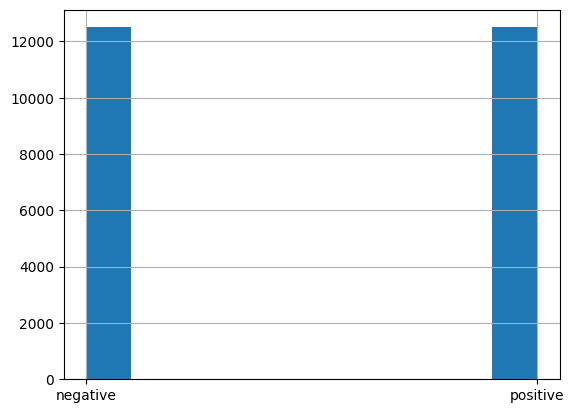

In [155]:
train_df.sentiment.hist()

Now that the preprocessing is done, let us split the data into two segments - one segment that gives us a pool to draw few-shot examples from and another segment that gives us a pool of gold examples.

In summary (see figure below), we extract a dataset from a corpus by processing required fields. Each example should contain the text input and an annotated label. Once we create examples and gold examples from this dataset, this curated dataset is stored in a format appropriate for reuse (e.g., JSON).

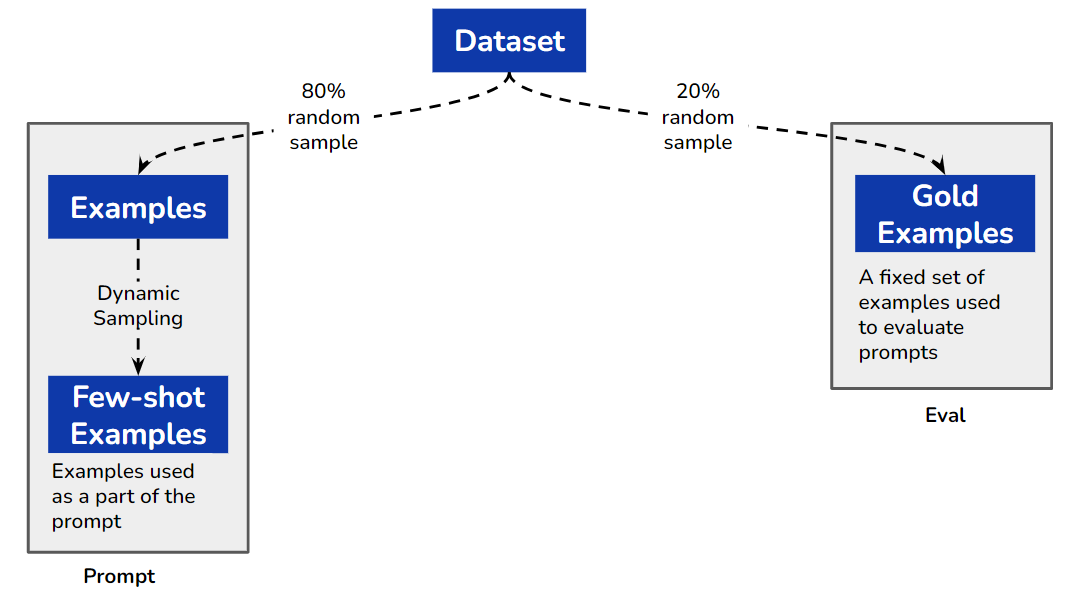

In [76]:
examples_df, gold_examples_df = train_test_split(
    train_df, test_size=0.2, random_state=42 
)

In [77]:
(examples_df.shape, gold_examples_df.shape)

((20000, 3), (5000, 3))

To select gold examples for this session, we sample randomly from the test data using a `random_state=42`. This ensures that the examples from multiple runs of the sampling are the same (i.e., they are randomly selected but do not change between different runs of the notebook). Note that we are doing this only to keep execution times low for illustration. In practise, large number of gold examples facilitate robust estimates of model accuracy.

In [114]:
columns= ['text', 'sentiment']
gold_examples = ( gold_examples_df.loc[:, columns].sample(20, random_state=42).to_json(orient='records'))

In [80]:
json.loads(gold_examples)[0]

{'text': 'Like I said at the top, four stars just aren\'t enough. It\'s one of the best films I\'ve ever seen in my almost 17 years of life. For the people that don\'t really like it or understand it, you must not have a real appreciation for art or you might have a short attention span.<br /><br />Even if I haven\'t seen all his films yet, I\'d have to say that this is Spielberg at his peak. It\'s pretty sad to see that movies as great as "The Color Purple" don\'t come along too often \'cause I think all of us are in desperate need of first-class motion picture entertainment in these hard times.<br /><br />Movies like this are more than just movies; they\'re pieces of art that need to be appreciated more.<br /><br />The idea that it was nominated for 11 Oscars (even Best Picture of the Year) and didn\'t get one trophy is a sign of how blind and stupid Hollywood can be sometimes. Spielberg wasn\'t even nominated for Best Director! It should have swept the Oscars that year.<br /><br />T

### Step 3: Derive Prompt

#### Create prompts

In [81]:
user_message_template = """```{movie_review}```"""

**Prompt 1: Zero-shot**

In [126]:
zero_shot_system_message = """
Classify the sentiment of movie reviews presented in the input as 'positive' or 'negative'
Movie reviews will be delimited by triple backticks in the input.
Answer only 'positive' or 'negative' 
Do not explain your answer.
"""

In [83]:
zero_shot_prompt = [{'role':'system', 'content': zero_shot_system_message}]

**Prompt 2: Few-shot**

For the few-shot prompt, there is no change in the system message compared with the zero-shot prompt. However, we augment this system message with few shot examples.  

In [127]:
few_shot_system_message = """
Classify the sentiment of movie reviews presented in the input as 'positive' or 'negative'
Movie reviews will be delimited by triple backticks in the input.
Answer only 'positive' or 'negative'
Do not explain your answer.
"""

To assemble few-shot examples, we will need to sample the required number of reviews from the training data. One approach would be to  first subset positive and negative reviews and then select samples from these subsets like so (note how we assemble 8 few-shot examples in the code below):

In [85]:
positive_reviews = (examples_df.sentiment == 'positive')
negative_reviews = (examples_df.sentiment == 'negative')

In [86]:
(positive_reviews.shape, negative_reviews.shape)

((20000,), (20000,))

In [87]:
columns = ['text', 'sentiment']
positive_examples = examples_df.loc[positive_reviews, columns].sample(4)
negative_examples = examples_df.loc[negative_reviews, columns].sample(4)

In [88]:
positive_examples

,text,sentiment
19171,One of my favorite shows in the 80's. After th...,positive
22462,<br /><br />Presenting Lily Mars is one of a g...,positive
18428,Every movie critic and metal head hated this m...,positive
16281,When will people learn that some movies are ma...,positive


In [89]:
negative_examples

,text,sentiment
11058,TYSON <br /><br />Aspect ratio: 1.33:1<br /><b...,negative
4734,"This was a crappy movie, with a whole lotta no...",negative
4631,"This show is possibly the biggest, ugliest, mo...",negative
7971,Please! Do not waste any money on this movie. ...,negative


However, merely selecting random samples from the polarity subsets is not enough because the examples included in a prompt are prone to a set of known biases such as:
 - Majority label bias (frequent answers in predictions)
 - Recency bias (examples near the end of the prompt)


To avoid these biases, it is important to have a balanced set of examples that are arranged in random order. Let us create a Python function that generates bias-free examples (our function implements the workflow presented below):

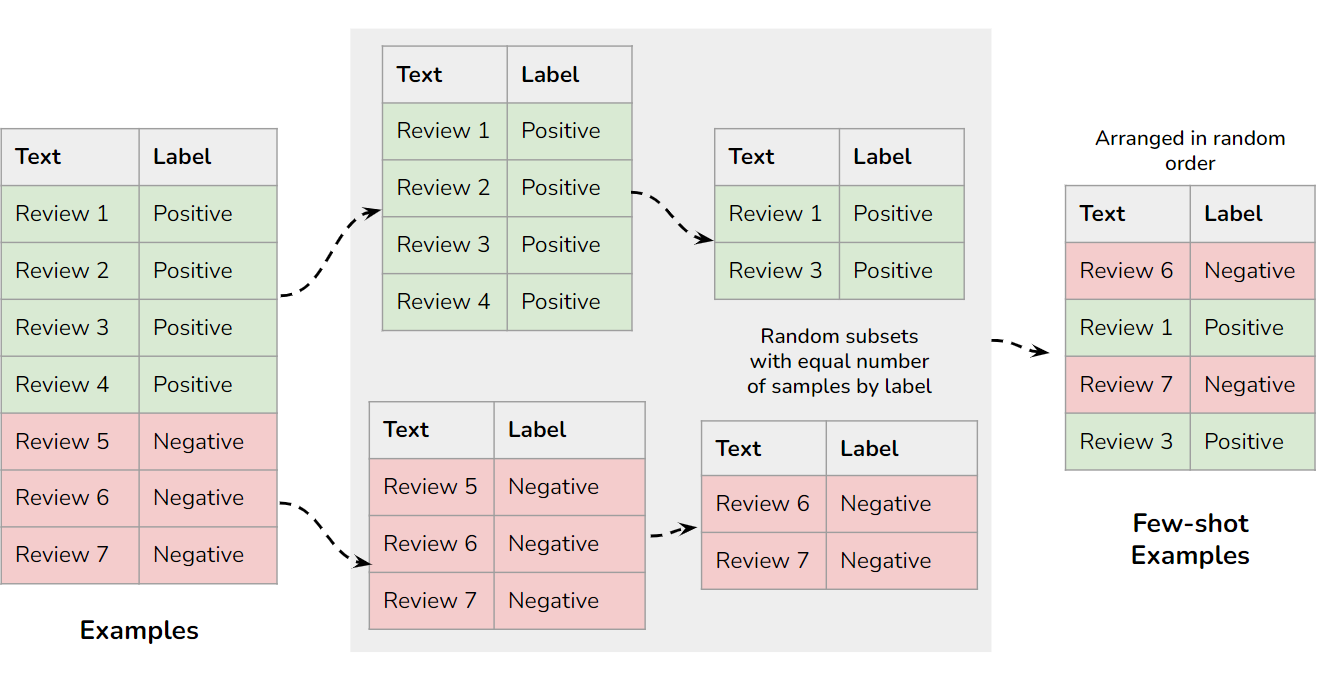

In [90]:
def create_examples(dataset, n=4):
    positive_reviews = (dataset.sentiment == 'positive')
    negative_reviews = (dataset.sentiment == 'negative')
    columns_to_select = ['text', 'sentiment']
    positive_examples = dataset.loc[positive_reviews, columns_to_select].sample(n)
    negative_examples = dataset.loc[negative_reviews, columns_to_select].sample(n)
    examples = pd.concat([positive_examples, negative_examples])
    # sampling without replacement is equivalent to random shuffling
    randomized_examples = examples.sample(2*n, replace=False)
    return randomized_examples.to_json(orient='records')

In [91]:
examples = create_examples(examples_df, 2)

In [92]:
json.loads(examples)

[{'text': "What can you say about this movie? It was not terrible, but it was not good! Two days earlier I had watched Lillies and that was one of the best Gay films I have ever seen. So this was not the best time to watch a mediocre Gay flick.<br /><br />The story was silly and the acting was OK. It was not bad enough to turn off, but it had some bad moments and some terrible stereotyping. It was not very well cast either.<br /><br />Would I recommend this movie? No you would be wasting your time and money. I don't understand why movies like these are made and who is funding them. Spend your time Watching Noah's Arc on Logo instead. I think this is where this movie was trying to go but never got there.",
  'sentiment': 'negative'},
 {'text': "I saw this movie at a college film festival back in the 70's - I have been waiting FOREVER for this movie to come out on video (finally it's out). It was made in Brazil, so I assumed that was why it hadn't made it to video yet. I have been checki

With the examples in place, we can now assemble a few-shot prompt. Since we will be using the few-shot prompt several times during evaluation, let us write a function to create a few-shot prompt (the logic of this function is depicted below).

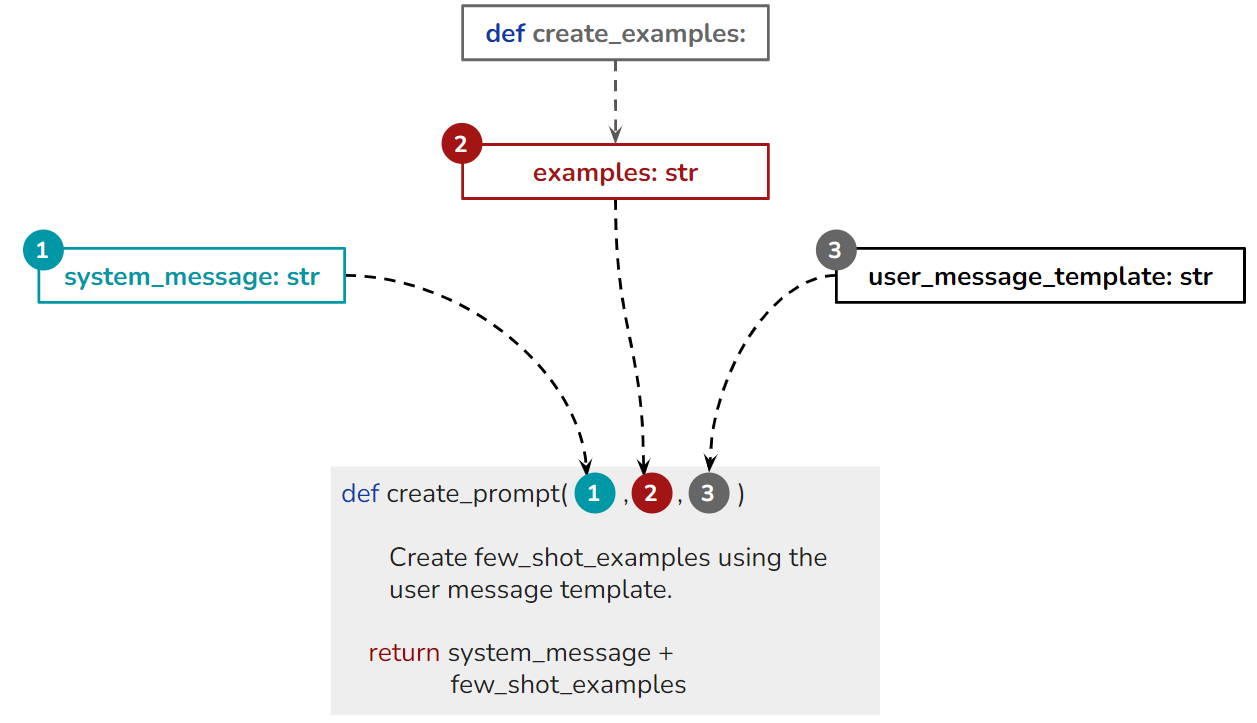

In [128]:
def create_prompt(system_message, examples, user_message_template):
    few_shot_prompt = [{'role':'system', 'content': system_message}]
    for example in json.loads(examples):
        example_review = example['text']
        example_sentiment = example['sentiment']
        few_shot_prompt.append(
            {
                'role': 'user',
                'content': user_message_template.format(
                    movie_review=example_review
                )
            }
        )
        few_shot_prompt.append(
            {'role': 'assistant', 'content': f"{example_sentiment}"}
        )
    return few_shot_prompt

In [129]:
few_shot_prompt = create_prompt(
    few_shot_system_message,
    examples,
    user_message_template
)

In [130]:
few_shot_prompt

[{'role': 'system',
  'content': "\nClassify the sentiment of movie reviews presented in the input as 'positive' or 'negative'\nMovie reviews will be delimited by triple backticks in the input.\nAnswer only 'positive' or 'negative'\nDo not explain your answer.\n"},
 {'role': 'user',
  'content': "```What can you say about this movie? It was not terrible, but it was not good! Two days earlier I had watched Lillies and that was one of the best Gay films I have ever seen. So this was not the best time to watch a mediocre Gay flick.<br /><br />The story was silly and the acting was OK. It was not bad enough to turn off, but it had some bad moments and some terrible stereotyping. It was not very well cast either.<br /><br />Would I recommend this movie? No you would be wasting your time and money. I don't understand why movies like these are made and who is funding them. Spend your time Watching Noah's Arc on Logo instead. I think this is where this movie was trying to go but never got ther

**Prompt 3: Chain-of-Thought**

For the CoT prompt, we add detailed step-by-step instructions to the few shot system message instructing the model to carefully ponder before assigning sentiment. Apart from this addition, there are no further changes from the few-shot prompt.

In [131]:
cot_system_message = """
Classify the sentiment of movie reviews presented in the input as 'positive' or 'negative'
Movie reviews will be delimited by triple backticks ``` in the input.
Answer only 'positive' or 'negative' 
Do not explain your answer.

Instructions:
1. Carefully read the text of the review and think through the options for sentiment provided
2. Consider the overall sentiment of the review and estimate the probability of the review being positive

To reiterate, your answer should strictly only contain the label: positive or negative
"""

In [132]:
cot_few_shot_prompt = create_prompt(cot_system_message, examples, user_message_template)

In [133]:
cot_few_shot_prompt

[{'role': 'system',
  'content': "\nClassify the sentiment of movie reviews presented in the input as 'positive' or 'negative'\nMovie reviews will be delimited by triple backticks in the input.\nAnswer only 'positive' or 'negative' \nDo not explain your answer.\n\nInstructions:\n1. Carefully read the text of the review and think through the options for sentiment provided\n2. Consider the overall sentiment of the review and estimate the probability of the review being positive\n\nTo reiterate, your answer should strictly only contain the label: positive or negative\n"},
 {'role': 'user',
  'content': "```What can you say about this movie? It was not terrible, but it was not good! Two days earlier I had watched Lillies and that was one of the best Gay films I have ever seen. So this was not the best time to watch a mediocre Gay flick.<br /><br />The story was silly and the acting was OK. It was not bad enough to turn off, but it had some bad moments and some terrible stereotyping. It was

Note that the examples remain the same while the system message changes.

#### Evaluate prompts

Now we have three sets of prompts that we need to evaluate using gold labels. Since the few-shot prompt and the CoT prompt depend on the sample of examples that was drawn to make up the prompt, we expect some variability in evaluation. Hence, we evaluate each prompt multiple times to get a sense of the average and the variation around the average.

To reiterate, a choice on the prompt should account for variability due to the choice of the random sample. To aid repeated evaluation, we assemble an evaluation function (overall logic depicted in the figure below).

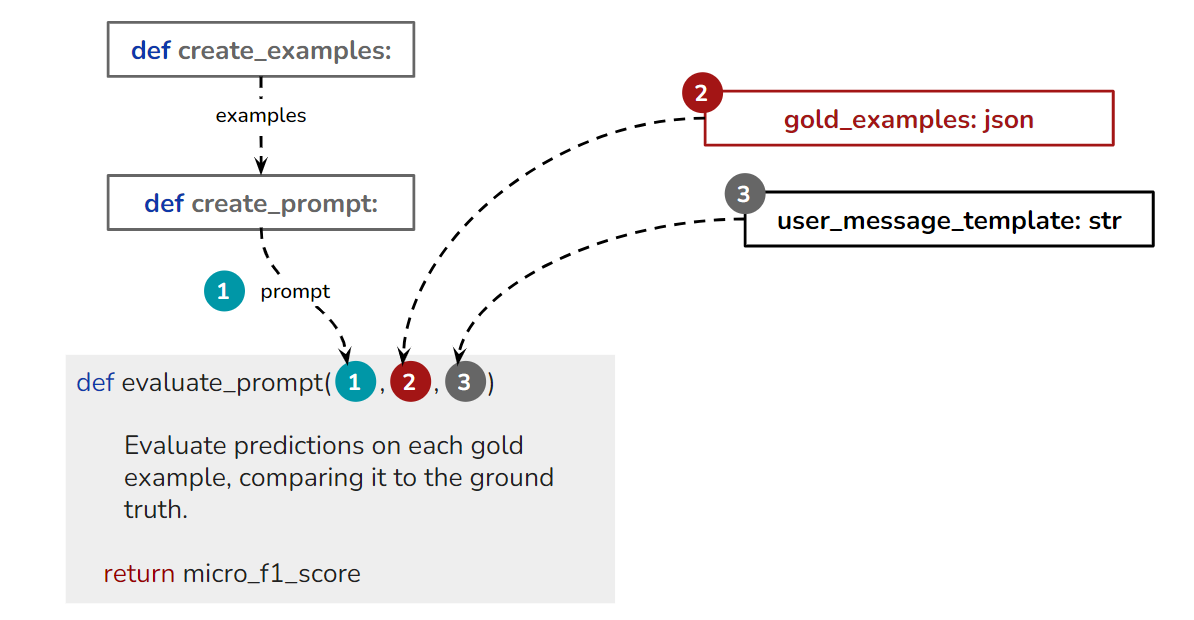

In [150]:
def evaluate_prompt(prompt, gold_examples, user_message_template, model):
    model_predictions, ground_truths = [], []

    for example in json.loads(gold_examples):
        gold_input = example['text']
        user_input = [
            {
                'role':'user',
                'content': user_message_template.format(movie_review=gold_input)
            }
        ]

        try:
            response = model.invoke(
               prompt+user_input
            )
            if hasattr (response, 'content'):
                response_content = response.content
            else:
                response_content = response    
            if 'negative' in response_content.strip().lower():
                prediction='negative'
            elif 'positive' in response_content.strip().lower():
                prediction='positive'
            else:
                prediction ='unknown'
            model_predictions.append(prediction)
            ground_truths.append(example['sentiment'])
            print(prediction, example['sentiment'])

        except Exception as e:
            print(e)
            continue

    micro_f1_score = f1_score(ground_truths, model_predictions, average="micro")

    return micro_f1_score

Let us now use this function to do one evaluation of all the three prompts assembled so far, each time computing the Micro-F1 score.

In [153]:
evaluate_prompt(zero_shot_prompt, gold_examples, user_message_template, llama_llm)

positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive


1.0

In [142]:
evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive


1.0

In [143]:
evaluate_prompt(cot_few_shot_prompt, gold_examples, user_message_template)

positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive


1.0

However, this is just *one* choice of examples. We will need to run these evaluations with multiple choices of examples to get a sense of variability in F1 score for the few-shot prompt and the CoT prompt. As an example, let us run evaluations for the few-shot prompt and the CoT prompt 10 times.

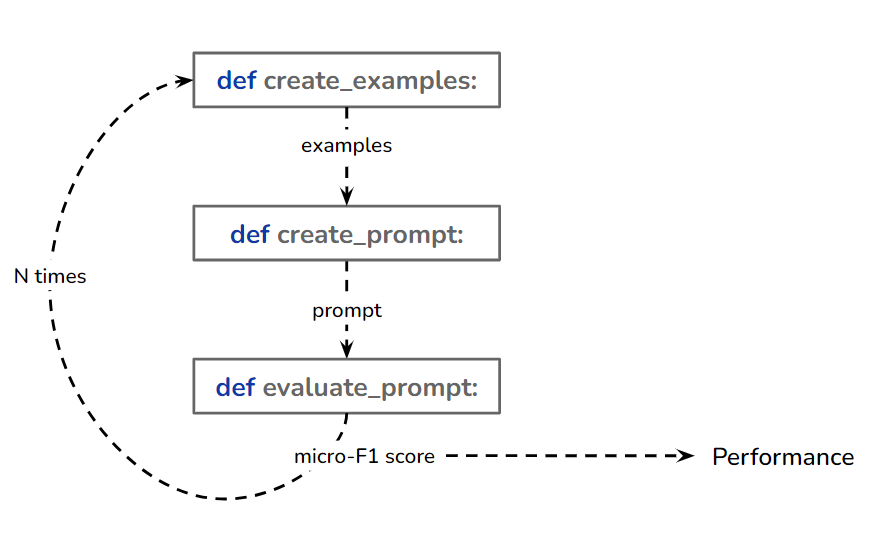

In [144]:
num_eval_runs = 10

In [145]:
few_shot_performance, cot_few_shot_performance = [], []

In [147]:
for _ in tqdm(range(num_eval_runs)):

    # For each run create a new sample of examples
    examples = create_examples(examples_df)

    # Assemble the few shot prompt with these examples
    few_shot_prompt = create_prompt(few_shot_system_message, examples, user_message_template)
    cot_few_shot_prompt = create_prompt(cot_system_message, examples, user_message_template)

    # Evaluate prompt accuracy on gold examples
    few_shot_micro_f1 = evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)
    cot_few_shot_micro_f1 = evaluate_prompt(cot_few_shot_prompt, gold_examples, user_message_template)

    few_shot_performance.append(few_shot_micro_f1)
    cot_few_shot_performance.append(cot_few_shot_micro_f1)

  0%|          | 0/10 [00:00<?, ?it/s]

positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 10%|█         | 1/10 [00:41<06:09, 41.06s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 20%|██        | 2/10 [01:24<05:41, 42.69s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 30%|███       | 3/10 [02:08<05:00, 42.99s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 40%|████      | 4/10 [02:50<04:16, 42.81s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 50%|█████     | 5/10 [03:37<03:40, 44.19s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 60%|██████    | 6/10 [04:24<03:00, 45.09s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 70%|███████   | 7/10 [05:05<02:11, 43.69s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 80%|████████  | 8/10 [05:49<01:27, 43.96s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 90%|█████████ | 9/10 [06:45<00:47, 47.59s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


100%|██████████| 10/10 [07:32<00:00, 45.23s/it]

positive positive


In [148]:
np.array(few_shot_performance).mean(), np.array(few_shot_performance).std()

(1.0, 0.0)

In [149]:
np.array(cot_few_shot_performance).mean(), np.array(cot_few_shot_performance).std()

(1.0, 0.0)

We want less variability in the F1 scoress across multiple evaluations. In this case, there is no major difference between the few-shot prompt and the CoT prompt after accounting for the variation due to the samples chosen as examples.

Once a prompt type has been identified, we will need to put this prompt through two sensitivity tests:
- bias check using a content-free input.
- number of examples check.

*Check 1: Bias*

We check if the prompt is generating a biased response by presenting a content free input (usually a blank, the string `nothing` or `N/A`). This check also acts as a guardrail for the situation where customer input is improperly received.

In [ ]:
bias_test_predictions = []

In [ ]:
for _ in tqdm(range(25)):

    user_input = [
        {
            'role':'user',
            'content': "```' '```" #<- content free test input
        }
    ]

    response = openai.ChatCompletion.create(
        deployment_id=chat_model_id,
        messages=few_shot_prompt+user_input,
        temperature=0,
        max_tokens=2
    )

    prediction = response['choices'][0]['message']['content']

    bias_test_predictions.append(prediction.strip().lower())

100%|██████████| 25/25 [00:05<00:00,  4.97it/s]


In [ ]:
Counter(bias_test_predictions)

Counter({"i'm": 25})

The model should correctly identify that no review was presented to the model and not assign a label as instructed in the system message (rerun this multiple times; we should always get a single label).

*Check 2: Sensitivity to number of examples*

To check if the performance of the prompt is sensitive to the number of examples used in the prompt, we vary the number of examples and ascertain that there is no dramatic difference in performance.

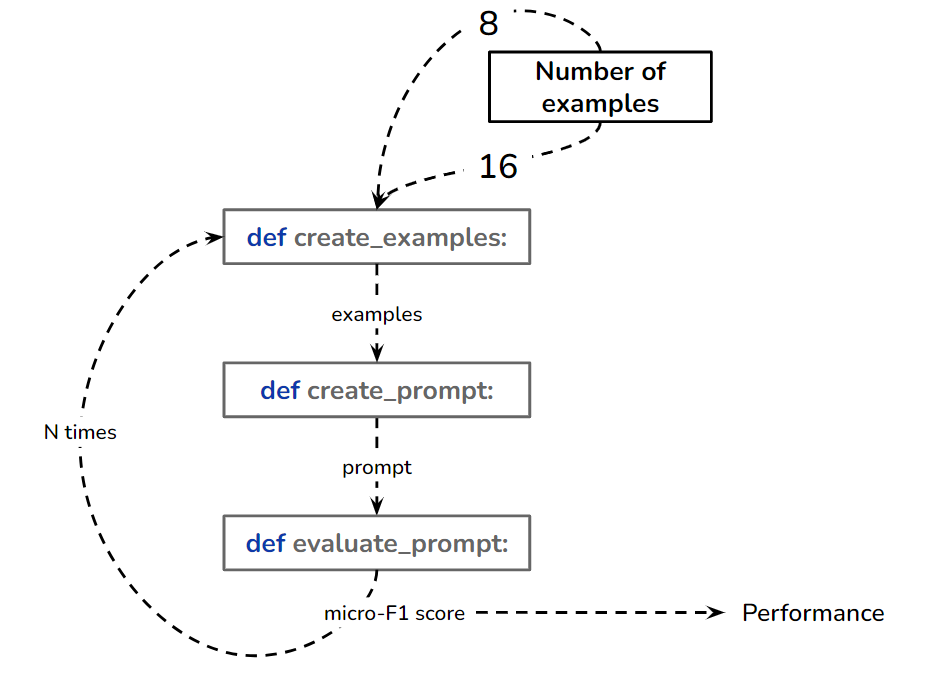

In [ ]:
sample_size_sensitivity_results = []
per_class_examples_choice = [2, 3]

In [ ]:
for n in tqdm(per_class_examples_choice):

    for _ in range(10):

        examples = create_examples(imdb_reviews_examples_df, n)

        few_shot_prompt = create_prompt(few_shot_system_message, examples, user_message_template)

        few_shot_micro_f1 = evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

        sample_size_sensitivity_results.append({'num_examples': 2*n, 'micro_f1': few_shot_micro_f1})

100%|██████████| 2/2 [06:15<00:00, 187.63s/it]


In [ ]:
pd.DataFrame(sample_size_sensitivity_results).groupby('num_examples').agg(['mean', 'std'])

micro_f1          
                  mean       std
num_examples                    
4             0.975000  0.008784
6             0.977083  0.006588

The performance is not sensitive to the number of examples (less examples $⇒$ less tokens $⇒$ less cost). Larger prompts also have the risk of exceeding the context window.

## Task 2: Aspect-Based Sentiment Analysis (ABSA)

So far, we have been concerned with the overall sentiment of the input. However, when there are several aspects ("themes") that are included in the input text, it is not necessary that all the aspects of the input share the same sentiment. For example, when reviewing a mobile phone, a customer might express sentiment about the different features of the phone (e.g., camera, storage, screen, processor) and these features might not share the same sentiment. It is likely that while the customer liked the camera, they expressed concern about the storage on the phone.

In aspect-based sentiment analysis (ABSA), the aim is to identify the aspects of entities and the sentiment expressed for each aspect. The ultimate goal is to be able to generate a measure of polarity that explicitly accounts for the different aspects of the input. In this way, ABSA presents a nuanced version of the overall polarity of the sentiment expresses in the input. For effective ABSA, we should be able to generate appropriate themes and then assign sentiment to the portions of the input that correspond to this theme.

### Step 1: Define objectives & Metrics

As in the case of sentiment analysis discussed in the previous task, we assign positive or negative sentiment to a review, with the additional objective of identifying entities (if any) present in the review.

To evaluate model performance, we judge the accuracy of the aspects + sentiment assignnment per aspect. Note that this is a much more stringent measure compared to the sentiment classification task we have seen so far. For example, if aspects identified by the LLM do not match the ground truth for a specific input, we count this prediction to be incorrect. A correct prediction is one where all the aspects are correctly idenfied and further the sentiment assignment for each aspect is also correctly identified (see figure below).

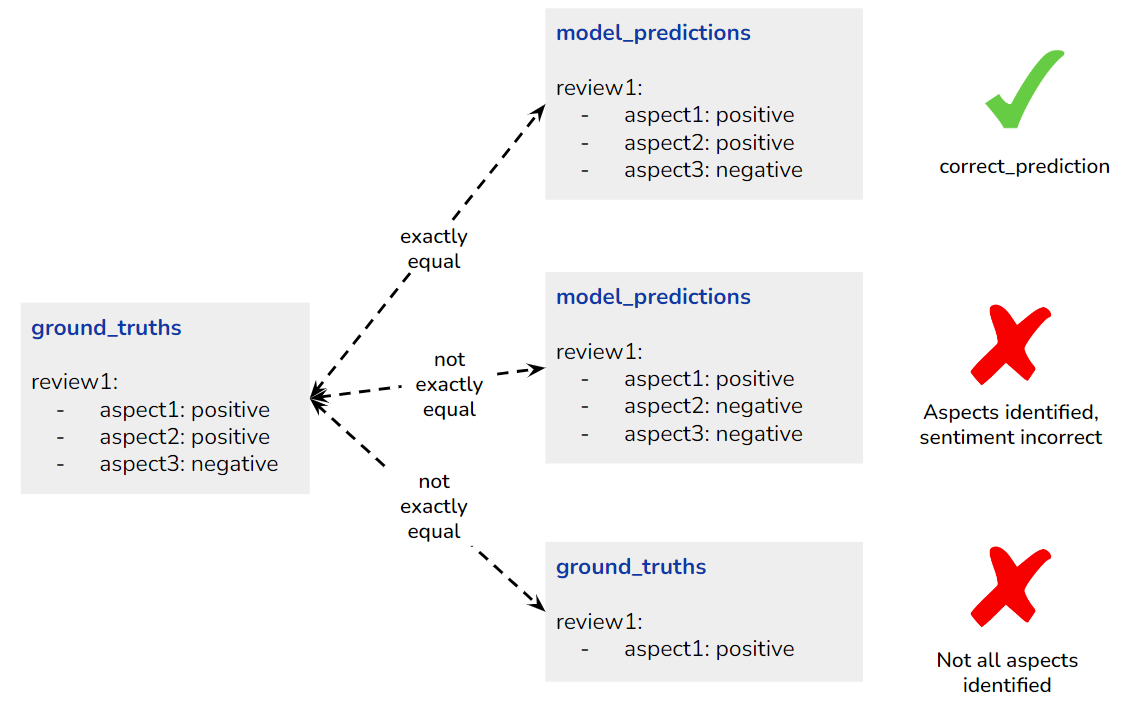

In [ ]:
def compute_accuracy(gold_examples, model_predictions, ground_truths):

    """
    Return the accuracy score comparing the model predictions and ground truth
    for ABSA. We look for exact matches between the model predictions on all the
    aspects and sentiments for these aspects in the ground truth.

    Args:
        gold_examples (str): JSON string with list of gold examples
        model_predictions (List): Nested list of ABSA predictions
        ground_truths (List): Nested list of ABSA annotations

    Output:
        accuracy (float): Exact matches of model predictions and ground truths
    """
    # Initialize variables to keep track of correct and total predictions
    correct_predictions = 0
    total_predictions = len(gold_examples)

    # Iterate through each prediction and ground truth pair
    for pred, truth in zip(model_predictions, ground_truths):
        if pred == truth:
            correct_predictions += 1

    # Calculate accuracy as the ratio of correct predictions to total predictions
    accuracy = correct_predictions / total_predictions

    return accuracy

### Step 2: Assemble Data

To illustrate ABSA, we use a restaurant dataset that was annotated with 3 entity types (`food`, `service`, `ambience`) that might be present in each review and an assignment of sentiment (`positive`, `negative` or `neutral`) for the entities present in the review. For reviews that do not have any of these 3 aspects the category - `anecdotes/miscellaneous` - is assigned as the aspect along with the corresponding sentiment.

In [ ]:
aspect_based_restaurant_reviews_corpus = load_dataset("jakartaresearch/semeval-absa", "restaurant")

In [ ]:
aspect_based_restaurant_reviews_corpus

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'aspects', 'category'],
        num_rows: 3044
    })
    validation: Dataset({
        features: ['id', 'text', 'aspects', 'category'],
        num_rows: 800
    })
})

We follow an approach similar to the one adopted for movie reviews and carve out two sections of the data - one for examples and another for gold examples.

In [ ]:
restaurant_reviews_train_df = aspect_based_restaurant_reviews_corpus['train'].to_pandas()

In [ ]:
restaurant_reviews_examples_df, restaurant_reviews_gold_examples_df = train_test_split(
    restaurant_reviews_train_df, #<- the full dataset
    test_size=0.2, #<- 20% random sample selected for gold examples
    random_state=42 #<- ensures that the splits are the same for every session
)

In [ ]:
restaurant_reviews_examples_df.sample(10)

,id,text,aspects,category
1275,1814,hmmm.,"{'term': [''], 'polarity': [''], 'from': [0], ...","{'category': ['anecdotes/miscellaneous'], 'pol..."
588,1331,Why make a reservation if you aren't going to ...,"{'term': ['reservation'], 'polarity': ['negati...","{'category': ['service'], 'polarity': ['negati..."
1492,2792,A real dissapointment.,"{'term': [''], 'polarity': [''], 'from': [0], ...","{'category': ['anecdotes/miscellaneous'], 'pol..."
2904,3647,We were seated and ignored by waitstaff.,"{'term': ['waitstaff'], 'polarity': ['negative...","{'category': ['service'], 'polarity': ['negati..."
2325,1931,Truly the mark of an attentive waiter.,"{'term': ['waiter'], 'polarity': ['positive'],...","{'category': ['service'], 'polarity': ['positi..."
1371,3148,Ive asked a cart attendant for a lotus leaf wr...,"{'term': ['cart attendant', 'lotus leaf wrappe...","{'category': ['service'], 'polarity': ['negati..."
395,2229,It's convenient.,"{'term': [''], 'polarity': [''], 'from': [0], ...","{'category': ['anecdotes/miscellaneous'], 'pol..."
2352,116,I have known about this secret for the last 13...,"{'term': ['food', 'wine', 'prices'], 'polarity...","{'category': ['price', 'food'], 'polarity': ['..."
1635,3505,When he's not making authentic Neapolitan pizz...,"{'term': ['Neapolitan pizza', 'zucchini blosso...","{'category': ['service', 'food'], 'polarity': ..."
2326,181,"The food here is rather good, but only if you ...","{'term': ['food'], 'polarity': ['positive'], '...","{'category': ['food', 'service'], 'polarity': ..."


As we can see from the table above, the polarity assignment by aspect is present in the `category` column where the categories and polarity of the review on the aspect are stored as lists. Not all reviews have aspects identified (e.g., 'Oh boy!') and these reviews are mapped to the `anecdotes/miscellaneous` aspect.

Let us take stock of how many reviews are identified to contain the aspects mentioned in the task. One way to do this is to create a lookup index with each of the aspects as keys and a list of all reviews that are annotated with the aspect as the value.

To create this index, we start with a dictionary of aspects in  the task

In [ ]:
examples_aspect_index = {
    'food': [],
    'service': [],
    'ambience': [],
    'anecdotes/miscellaneous': []
}

gold_examples_aspect_index = {
    'food': [],
    'service': [],
    'ambience': [],
    'anecdotes/miscellaneous': []
}

Now, we can loop over the `id` and `category` of each review and add the `id` to the corresponding aspect (key) if the aspect is present in the `category`.

In [ ]:
for id, category in zip(restaurant_reviews_examples_df.id, restaurant_reviews_examples_df.category):
    for key in examples_aspect_index.keys():
        if key in category['category'].tolist():
            examples_aspect_index[key].append(id)

Distribution of aspects in examples.

In [ ]:
for key in examples_aspect_index:
    print(f"Number of examples for aspect {key}: {len(examples_aspect_index[key])}")

Number of examples for aspect food: 985
Number of examples for aspect service: 484
Number of examples for aspect ambience: 343
Number of examples for aspect anecdotes/miscellaneous: 914


Distribution of aspects in gold examples.

In [ ]:
for id, category in zip(restaurant_reviews_gold_examples_df.id, restaurant_reviews_gold_examples_df.category):
    for key in gold_examples_aspect_index.keys():
        if key in category['category'].tolist():
            gold_examples_aspect_index[key].append(id)

In [ ]:
for key in gold_examples_aspect_index:
    print(f"Number of examples for aspect {key}: {len(gold_examples_aspect_index[key])}")

Number of examples for aspect food: 248
Number of examples for aspect service: 113
Number of examples for aspect ambience: 89
Number of examples for aspect anecdotes/miscellaneous: 217


In [ ]:
columns_to_select = ['id', 'text', 'category']

In [ ]:
gold_examples = json.loads((
        restaurant_reviews_gold_examples_df.loc[:, columns_to_select]
                                           .sample(30, random_state=42) #<- ensures that gold examples are the same for every session
                                           .to_json(orient='records')
))

In [ ]:
gold_examples[0]

{'id': '2973',
 'text': 'The food was amazing, and the service was prompt and helpful, but not over-bearing or rushed.',
 'category': {'category': ['food', 'service'],
  'polarity': ['positive', 'positive']}}

### Step 3: Derive Prompt

The functions that we used to assemble examples, create prompts and to evaluate these prompts are broadly the same as in the case of sentiment analysis. However, we should adapt the few-shot examples to now account for the multiple aspects.

#### Create prompts

In [ ]:
user_message_template = """```{restaurant_review}```"""

**Zero-shot prompt**

In [ ]:
zero_shot_system_message = """
Perform aspect based sentiment analysis on restaurant reviews presented in the input delimited by triple backticks, that is, ```.
In each review there might be one or more of the following aspects: food, service, ambience, anecdotes/miscellaneous.
For each review presented as input:
- Identify if there are any of the 4 aspects (food, service, ambience, anecdotes/miscellaneous) present in the review.
- Assign a sentiment polarity (positive, negative or neutral) for each aspect

Arrange your response a JSON object with the following headers:
- category:[list of aspects]
- polarity:[list of corresponding polarities for each aspect]}
"""

In [ ]:
zero_shot_prompt = [{'role':'system', 'content': zero_shot_system_message}]

In [ ]:
num_tokens_from_messages(zero_shot_prompt)

137

**Few-shot prompt**

In [ ]:
few_shot_system_message = """
Perform aspect based sentiment analysis on restaurant reviews presented in the input delimited by triple backticks, that is, ```.
In each review there might be one or more of the following aspects: food, service, ambience, anecdotes/miscellaneous.
For each review presented as input:
- Identify if there are any of the 4 aspects (food, service, ambience, anecdotes/miscellaneous) present in the review.
- Assign a sentiment polarity (positive, negative or neutral) for each aspect

Arrange your response a JSON object with the following headers:
- category:[list of aspects]
- polarity:[list of corresponding polarities for each aspect]}
"""

Let us now look at how we can assemble examples to go along with this few-shot system message and compose a few-shot prompt.

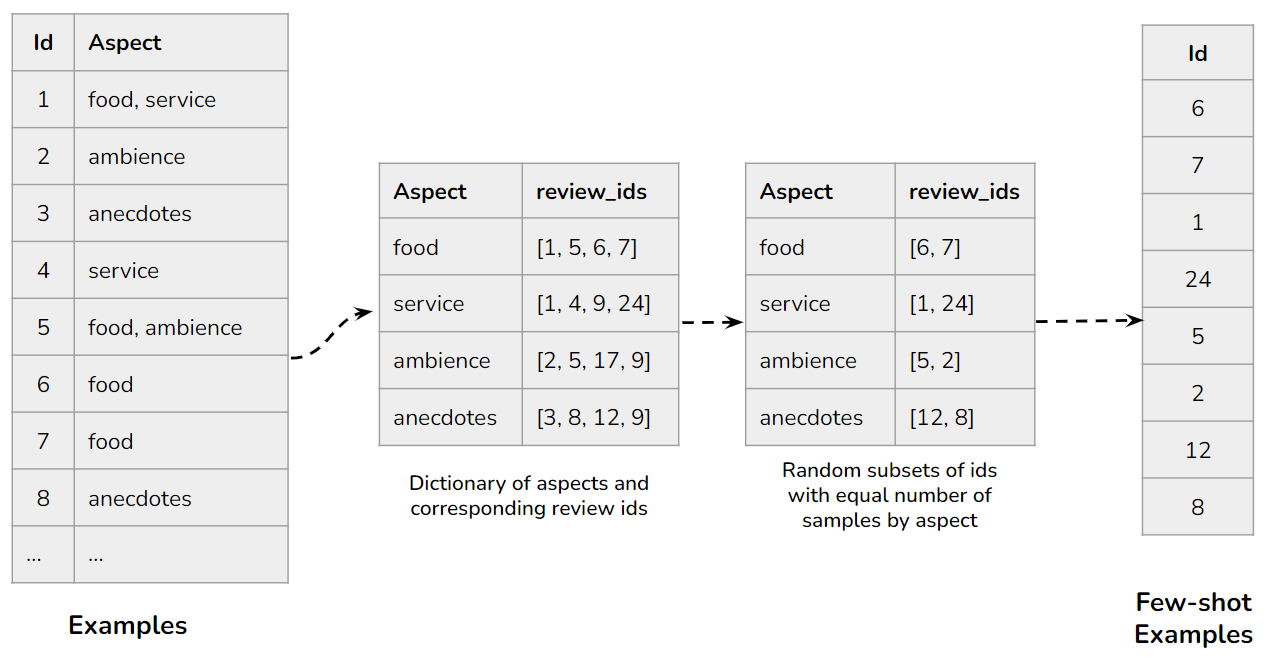

In [ ]:
def create_examples(dataset, n=4):

    """
    Return a JSON list with n random examples of each aspect in the
    input dataset.
    First create a dictionary with the aspects as keys and the ids of the
    reviews that contain this aspect as values.
    Then take a random sample of ids from each of these lists.

    Args:
        dataset (DataFrame): DataFrame with nested ABSA annotations
        n (int): Number of random examples selected for each aspect

    Output:
        examples (JSON): JSON list of examples
    """

    columns_to_select = ['id', 'text', 'category']
    example_ids = []

    aspect_index = {
        'food': [], 'service': [], 'ambience': [], 'anecdotes/miscellaneous': []
    }

    for id, category in zip(dataset.id, dataset.category):
        for key in aspect_index.keys():
            if key in category['category'].tolist():
                aspect_index[key].append(id)

    for key in aspect_index:
        example_ids.extend(np.random.choice(aspect_index[key], n).tolist())

    examples = dataset.loc[dataset.id.isin(example_ids), columns_to_select]

    return examples.to_json(orient='records')

In [ ]:
def create_prompt(system_message, examples, user_message_template):

    """
    Return a prompt message in the format expected by the Open AI API.
    Loop through the examples and parse them as user message and assistant
    message.

    Args:
        system_message (str): Instructions for the model to execute ABSA
        examples (JSON): JSON list of examples representative of each aspect
        user_message_template (str): string with a placeholder for restaurant reviews

    Output:
        few_shot_prompt (List): A list of dictionaries in the Open AI prompt format
    """

    few_shot_prompt = [{'role':'system', 'content': system_message}]

    for example in json.loads(examples):
        example_input = example['text']
        example_absa = example['category']

        few_shot_prompt.append(
            {
                'role': 'user',
                'content': user_message_template.format(
                    restaurant_review=example_input
                )
            }
        )

        few_shot_prompt.append(
            {'role': 'assistant', 'content': f"{example_absa}"}
        )

    return few_shot_prompt

In [ ]:
examples = create_examples(restaurant_reviews_train_df)
few_shot_prompt = create_prompt(few_shot_system_message, examples, user_message_template)

#### Evaluate prompts

In [ ]:
def evaluate_prompt(prompt, gold_examples, user_message_template):

    """
    Return the accuracy score for predictions on gold examples.
    For each example, we make an ABSA prediction using the prompt.
    Gold labels and model predictions are aggregated into lists and presented to
    the compute_accuracy function.

    Args:
        prompt (List): list of messages in the Open AI prompt format
        gold_examples (str): JSON string with list of gold examples
        user_message_template (str): string with a placeholder for movie reviews

    Output:
        accuracy (float): Accuracy computed by comparing model predictions
                                with ground truth
    """

    model_predictions, ground_truths = [], []

    for example in gold_examples:
        user_input = [
            {
                'role':'user',
                'content': user_message_template.format(restaurant_review=example['text'])
            }
        ]

        try:
            response = openai.ChatCompletion.create(
                deployment_id=chat_model_id,
                messages=prompt+user_input,
                temperature=0
            )

            prediction = response['choices'][0]['message']['content'].replace("'", "\"")

            model_predictions.append(json.loads(prediction.strip().lower()))
            ground_truths.append(example['category'])

        except Exception as e:
            continue

    accuracy = compute_accuracy(gold_examples, model_predictions, ground_truths)

    return accuracy

In [ ]:
evaluate_prompt(zero_shot_prompt, gold_examples, user_message_template)

0.4

In [ ]:
evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

0.6

In [ ]:
num_eval_runs = 10

In [ ]:
few_shot_performance = []

In [ ]:
for _ in tqdm(range(num_eval_runs)):

    # For each run create a new sample of examples
    examples = create_examples(restaurant_reviews_train_df)

    # Assemble the few shot prompt with these examples
    few_shot_prompt = create_prompt(few_shot_system_message, examples, user_message_template)

    # Evaluate prompt accuracy on gold examples
    few_shot_accuracy = evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

    few_shot_performance.append(few_shot_accuracy)

100%|██████████| 10/10 [01:54<00:00, 11.47s/it]


In [ ]:
np.array(few_shot_performance).mean(), np.array(few_shot_performance).std()

(0.6666666666666667, 0.039440531887330765)

# Summary

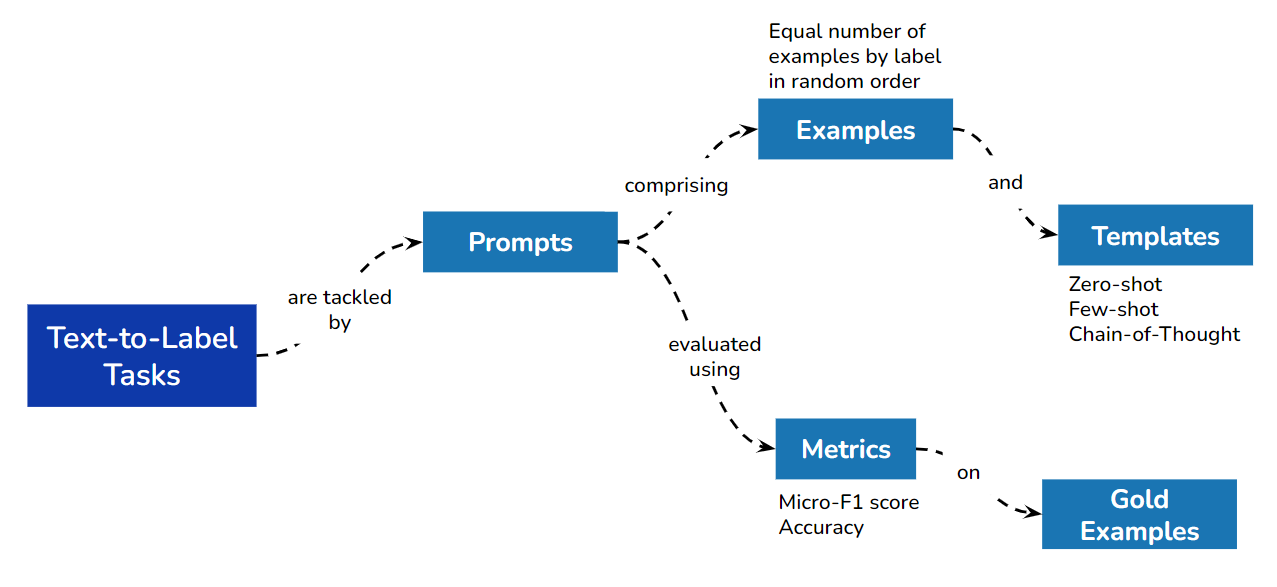